<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Two_Binomial_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
## Final 2023 mar 3 2pm 
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [2]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
pand

In [3]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy
from scipy.stats import fisher_exact, binom


## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

#To caluate math function 
import math

sns.set_style('darkgrid')

In [4]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

# Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory


In [5]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory
##
#####################################

In [6]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [7]:
## Sample size by math
# q: Proportion of subjects that are in Group 1 (exposed
# Effect size (If μ1 = mean in Group 1 and μ0 = mean in Group 0, then E = μ1 - μ0.)
def samp_size_2props(alpha, beta, q1, q0, p1, p0):
    P = (q1*p1) + (q0*p0)
    A = scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)* math.sqrt( P*(1-P)*(1/q1 + 1/q0) )
    B = scipy.stats.norm.ppf(q=beta, loc=0, scale=1)* math.sqrt( p1*(1-p1)*(1/q1) + p0*(1-p0)*(1/q0) )
    C = (p1-p0)**2
    n = (A+B)**2/C/2
    return(n)


In [8]:
samp_size_2props(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, p1=0.3, p0=0.2) #586



293.1512855064871

#  Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation

In [54]:
# test for preparing

# np.random.binomial(n=10, p=0.5, size=5).tolist() + np.random.binomial(n=10, p=0.5, size=5).tolist()
# [7, 5, 3, 4, 6, 5, 6, 4, 5, 6]
# np.random.binomial(n=10, p=0.5, size=5) + np.random.binomial(n=10, p=0.5, size=5)
# array([ 8, 10,  8, 12, 13])

In [10]:
def twobinorm_prop_samp_size(p0, p1, size):
    ## Generate random data
    # n trials and p probability of success 
    x0 = np.random.binomial(n= 1, p = p0, size = size).tolist()
    x1 = np.random.binomial(n= 1, p = p1, size = size).tolist()
    g1 = ["group1"] * len(x0)
    g2 = ["group2"] * len(x1)
    x = x0 + x1 # this have length 2n
    g = g1 + g2 # this have length 2n
    
    ## Analyze generated/simulated data
    n1 = sum(x0)
    n2 = sum(x1)
   
    table_xg = [
        [n1, len(x0)-n1], 
        [n2, len(x1)-n2]
    ]
    
    res = fisher_exact(table_xg, alternative="two-sided")
    
    ## Extract the estimate and CI
    pval = res[1]
    #ttest = res[0]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({#'ttest': [ttest], 
                        'pval': [pval], 
                        'tag': [tag]})
    return(out)


In [11]:
#n is smaller than size 
twobinorm_prop_samp_size(p0=0.1, p1=0.2, size=293) 

,pval,tag
0,0.000792,1


In [12]:
## Replicate above function number of simulation replicate times

# parameter available  
alpha=0.05
beta=0.2
q1=0.5
q0=0.5
p1=0.3
p0=0.2
n = 1
size=293


## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(twobinorm_prop_samp_size( p0, p1, size))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean 
sim_power = np.mean(sim_df, axis=0)
print(sim_power)

  0%|          | 0/10000 [00:00<?, ?it/s]

pval    0.054224
tag     0.778700
dtype: float64


In [13]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [sim_power[0]],
    'power': [sim_power[1]]
})

sim_results

,runtime,pvalue,power
0,47.462919,0.054224,0.7787


# Sample size estimation by GAN simulation

In [14]:
import sys
 
path = 'logs.txt'
sys.stdout = open(path, 'w')

In [15]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_binormal(pop_p0, pop_p1, pop_size):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x0 = np.random.binomial(n= 1, p = pop_p0, size = pop_size)
    x1 = np.random.binomial(n= 1, p = pop_p1, size = pop_size)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({'x0': x0, 'x1': x1})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    # CTGAN doesnt need to be seeded
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out




In [16]:
# %%time
# %%capture output

## Parameters of normal parent distribution
p0 = 0.2
p1= 0.3
size = 293 
n = 10000

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_binormal(pop_p0=p0, pop_p1= p1, pop_size=size)
t1 = time()
fit_time = t1 - t0
fit_time

31.86396837234497

In [17]:
with open('logs.txt') as file:
    lines = file.readlines()

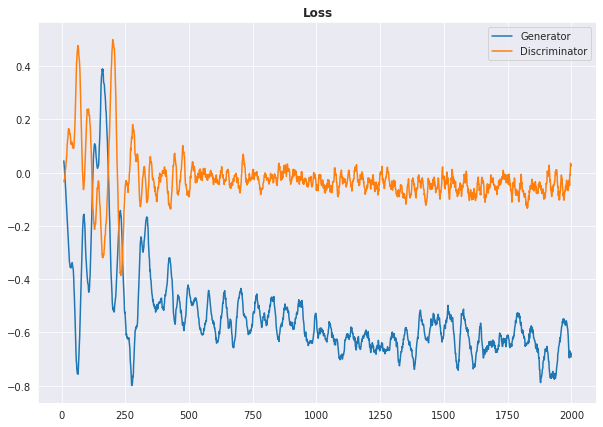

In [18]:
output = "".join(lines)
name = 'Loss'

output = StringIO(str(output))
window = 10

df = pd.read_csv(output, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.title(name, weight='bold')
plt.legend()
plt.show()

In [19]:
model_ = train_gan[0]

In [20]:
model_.sample(num_rows=10000).mean(axis=0)

x0    0.1607
x1    0.3953
dtype: float64

In [21]:
model_.get_parameters

<bound method BaseTabularModel.get_parameters of <sdv.tabular.ctgan.CTGAN object at 0x7f854f6c4040>>

In [22]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x0,x1
count,293.000000,293.000000
mean,0.197952,0.320819
std,0.399138,0.467590
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [23]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_2props(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, p1=0.3, p0=0.2)))

In [24]:
dat= model_.sample(num_rows=5)
dat

,x0,x1
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [25]:
dat.iloc[:, 0]

0    0
1    0
2    0
3    0
4    0
Name: x0, dtype: int64

In [26]:
dat.iloc[:, 1]

0    0
1    1
2    0
3    0
4    1
Name: x1, dtype: int64

In [27]:
dat["x0"]

0    0
1    0
2    0
3    0
4    0
Name: x0, dtype: int64

In [28]:
dat.iloc[:, 1]

0    0
1    1
2    0
3    0
4    1
Name: x1, dtype: int64

In [29]:
## Function to analyze data from the sampled model 
def twobinorm_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n)
    x0 = dat["x0"]
    x1 = dat["x1"]
    g1 = ["group1"] * len(x0)
    g2 = ["group2"] * len(x1)
    x = x0 + x1 # this have length 2n
    g = g1 + g2 # this have length 2n
    
    ## Analyze generated/simulated data
    n1 = sum(x0)
    n2 = sum(x1)
   
    table_xg = [
        [n1, len(x0)-n1], 
        [n2, len(x1)-n2]
    ]

    ## Analyze generated/simulated data
    res = fisher_exact(table_xg, alternative="two-sided")
    ## Extract the p value and power
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})

    # Return the estimate and the CI to the user
    return(out)

In [30]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(twobinorm_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_power = np.mean(gan_df, axis=0)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
gan_power

pval    0.000002
tag     1.000000
dtype: float64

In [32]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [gan_power[0]],
    'power': [gan_power[1]]
})

gan_results

,runtime,pvalue,power
0,25.505056,0.000002,1.0


In [33]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [66]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

# MUST BE A PARI HOWWWWWW EARSE ALL SAME SET ONES 

dictionary = {'alpha': [0.05], 
              'p0': [0.2,0.3,0.4],
              'p1': [0.3,0.4,0.5],
              'q1' :[0.5],
              'q0' :[0.5],
              'beta': [0.05, 0.1, 0.15, 0.2]} # changed 0.01 -> 0.05 to reduce training time

param_df = expand_grid(dictionary)
param_df = param_df[(param_df['p1'] > param_df['p0']) & ((param_df['p1'] - param_df['p0']) < 0.2)]
param_df = param_df.reset_index(drop=True)
param_df

,alpha,p0,p1,q1,q0,beta
0,0.05,0.2,0.3,0.5,0.5,0.05
1,0.05,0.2,0.3,0.5,0.5,0.10
2,0.05,0.2,0.3,0.5,0.5,0.15
3,0.05,0.2,0.3,0.5,0.5,0.20
4,0.05,0.3,0.4,0.5,0.5,0.05
5,0.05,0.3,0.4,0.5,0.5,0.10
6,0.05,0.3,0.4,0.5,0.5,0.15
7,0.05,0.3,0.4,0.5,0.5,0.20
8,0.05,0.4,0.5,0.5,0.5,0.05
9,0.05,0.4,0.5,0.5,0.5,0.10


In [68]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_2props(alpha=param_df.loc[i, 'alpha'], 
                        p0=param_df.loc[i, 'p0'],
                        p1=param_df.loc[i, 'p1'],
                        q1=param_df.loc[i, 'q1'], 
                        q0=param_df.loc[i, 'q0'],
                        beta=param_df.loc[i, 'beta']
                        )
    
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','p0','p1','q1','q0','beta','n_theory']
samp_size_theory_df

,alpha,p0,p1,q1,q0,beta,n_theory
0,0.05,0.2,0.3,0.5,0.5,0.05,485.0
1,0.05,0.2,0.3,0.5,0.5,0.10,392.0
2,0.05,0.2,0.3,0.5,0.5,0.15,336.0
3,0.05,0.2,0.3,0.5,0.5,0.20,294.0
4,0.05,0.3,0.4,0.5,0.5,0.05,589.0
5,0.05,0.3,0.4,0.5,0.5,0.10,477.0
6,0.05,0.3,0.4,0.5,0.5,0.15,407.0
7,0.05,0.3,0.4,0.5,0.5,0.20,356.0
8,0.05,0.4,0.5,0.5,0.5,0.05,641.0
9,0.05,0.4,0.5,0.5,0.5,0.10,519.0


In [69]:
########################
## 2) Sample Size for Power by Simulation from two binormal Distribution
########################

In [70]:
def twobinorm_power_samp_size(p0, p1, size):
  
    ## Generate random data
    x0 = np.random.binomial(n= 1, p = p0, size = size)
    x1 = np.random.binomial(n= 1, p = p1, size = size)
    
    g1 = ["group1"] * len(x0)
    g2 = ["group2"] * len(x1)
    x = x0 + x1 # this have length 2n
    g = g1 + g2 # this have length 2n
    
    ## Analyze generated/simulated data
    n1 = sum(x0)
    n2 = sum(x1)
   
    table_xg = [
        [n1, len(x0)-n1], 
        [n2, len(x1)-n2]
    ]
    
    ## Analyze generated/simulated data
    res = fisher_exact(table_xg, alternative="two-sided")
    
    ## Extract the estimate p value and tag 
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate p value and tag to the out
    out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})
    return(out)



In [77]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def twobinorm_power_samp_size_sim(p0, p1, size, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep, leave=False):
        sim_out.append(twobinorm_power_samp_size(p0=p0, p1=p1, size=size))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_power = np.mean(sim_df, axis=0)
    print(sim_power)

    sim_results = pd.DataFrame({'runtime': [runtime],
                                'pvalue': [sim_power[0]],
                                'power': [sim_power[1]]
      })

    return(sim_results)

In [78]:
power= twobinorm_power_samp_size_sim(p0=0.2, p1=0.3, size=10, n_rep=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [79]:
sim_results['power']

0    0.7787
Name: power, dtype: float64

In [80]:
power['power'].values[0]

0.0

In [81]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in trange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power = twobinorm_power_samp_size_sim(size=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          p0=samp_size_theory_df.loc[i, 'p0'],
                          p1=samp_size_theory_df.loc[i, 'p1'],
                          n_rep=n_rep)
    ## Round to largest integer
    power_ = power['power'].values[0]
    ## Append sample size to list
    samp_size_sim_list.append(power_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','p0','p1','q1','q0','beta','n_theory','power_sim']
samp_size_sim_df

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,alpha,p0,p1,q1,q0,beta,n_theory,power_sim
0,0.05,0.2,0.3,0.5,0.5,0.05,485.0,0.9423
1,0.05,0.2,0.3,0.5,0.5,0.10,392.0,0.8825
2,0.05,0.2,0.3,0.5,0.5,0.15,336.0,0.8251
3,0.05,0.2,0.3,0.5,0.5,0.20,294.0,0.7705
4,0.05,0.3,0.4,0.5,0.5,0.05,589.0,0.9453
5,0.05,0.3,0.4,0.5,0.5,0.10,477.0,0.8900
6,0.05,0.3,0.4,0.5,0.5,0.15,407.0,0.8322
7,0.05,0.3,0.4,0.5,0.5,0.20,356.0,0.7780
8,0.05,0.4,0.5,0.5,0.5,0.05,641.0,0.9445
9,0.05,0.4,0.5,0.5,0.5,0.10,519.0,0.8895


In [83]:
## Timing for the simulation experiments
sim_time

566.3349270820618

# Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution

In [82]:
import sys

In [90]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_twobinormal(pop_p0, pop_p1, pop_size):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x0 = np.random.binomial(n= 1, p = pop_p0, size = pop_size)
    x1 = np.random.binomial(n= 1, p = pop_p1, size = pop_size)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({'x0': x0, 'x1': x1})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

  0%|          | 0/3 [00:00<?, ?it/s]

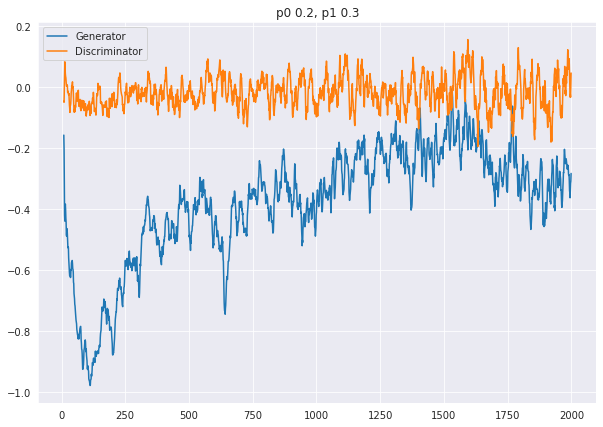

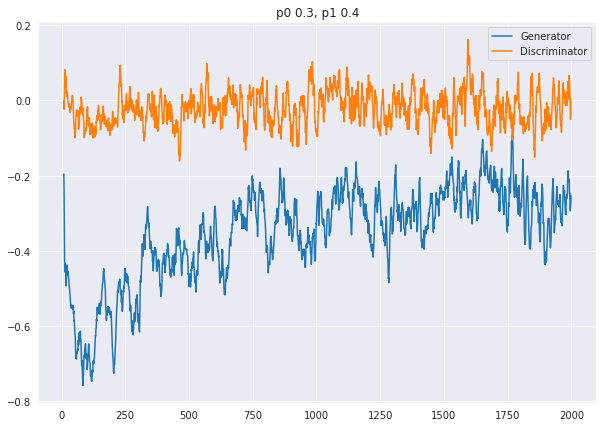

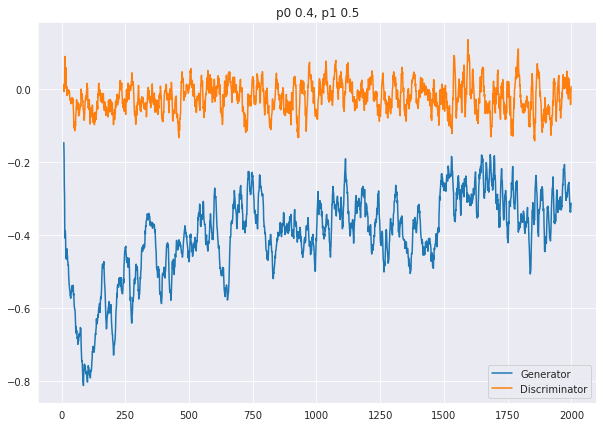

In [92]:
combinations = [
    {'p0': 0.2, 'p1': 0.3},
    {'p0': 0.3, 'p1': 0.4},
    {'p0': 0.4, 'p1': 0.5},
]
models = {}

for combination in tqdm(combinations):
    p0 = combination['p0']
    p1 = combination['p1']

    path = f'logs-p0-{p0}-p1-{p1}.txt'
    sys.stdout = open(path, 'w')

    pop_size = 10_000
    # training the GANs using the the big population so later can sampling from it for specific n theory
    
    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_twobinormal(pop_p0=p0, pop_p1=p1, pop_size=pop_size)
    
    models[f'p0-{p0}-p1-{p1}'] = train_gan[0]

    with open(f'logs-p0-{p0}-p1-{p1}.txt') as file:
        lines = file.readlines()

    output = "".join(lines)
    
    logs = StringIO(str(output))
    window = 10 # window size for the moving average, window=1 gets you the original series

    df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

    # I think a regex would be better here
    df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
    df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

    plt.figure(figsize=(10,7))

    # Plot with a moving average so it is less noisy
    plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
    plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

    plt.title(f'p0 {p0}, p1 {p1}')

    plt.legend()
    plt.show()

In [107]:
def twobinorm_power_samp_size_gan(model, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        dat = model.sample(num_rows=sim_n)
        x0 = dat["x0"]
        x1 = dat["x1"]
        g1 = ["group1"] * len(x0)
        g2 = ["group2"] * len(x1)
        x = x0 + x1 # this have length 2n
        g = g1 + g2 # this have length 2n
    
        ## Analyze generated/simulated data
        n1 = sum(x0)
        n2 = sum(x1)
   
        table_xg = [
        [n1, len(x0)-n1], 
        [n2, len(x1)-n2]
          ]

        ## Analyze generated/simulated data
        res = fisher_exact(table_xg, alternative="two-sided")
        
        ## Extract the p value and power
        pval = res[1]
        tag = np.where(pval<0.05, 1, 0)
        # Return the estimate and the CI to the user
        # [] make it a list instead of scalar
        out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})

        # Return the estimate and the CI to the user
        return(out)

def twobinorm_power_samp_size_gan_sim(model, sim_n, n_rep):
    ##
    ## Replicate above function number of simulation replicate times
    ##
    n_rep=1000
    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(twobinorm_power_samp_size_gan(model, sim_n=sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_power = np.mean(gan_df, axis=0)
    
    gan_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [gan_power[0]],
    'power': [gan_power[1]]
     })

    return(gan_results)

In [97]:
# ##
# ## WARNING...notice very subtle difference between pop_n and sim_n
# ##
# ## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
# ##
# ## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
# ##     --- larger values can also substantially increase training time for the GAN model
# ##

# t0 = time()

# tmp = twobinorm_power_samp_size_gan(pop_size=1000,
#                       pop_p0=0.2, 
#                       pop_p1=0.3, 
#                       sim_n=int(np.ceil(samp_size_2props(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, p1=0.3, p0=0.2))),
#                       n_rep=1000)

# t1 = time()

# [tmp, t1-t0]

In [114]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    p0 = samp_size_theory_df.loc[i, 'p0']
    p1 = samp_size_theory_df.loc[i, 'p1']
    sim_n = samp_size_theory_df.loc[i, 'n_theory']
    
  
    model = models[f'p0-{p0}-p1-{p1}']
    print(model)

    ## Compute sample size at particular parameter condiguration
    power = twobinorm_power_samp_size_gan_sim(
        model=model,
        sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
        n_rep=n_rep)
  
    ## Round to largest integer
    power_ = power['power'].values[0]
    ## Append sample size to list
    samp_size_gan_list.append(power_)


t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','p0','p1','q1','q0','beta','n_theory','power_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,p0,p1,q1,q0,beta,n_theory,power_gan
0,0.05,0.2,0.3,0.5,0.5,0.05,485.0,0.898
1,0.05,0.2,0.3,0.5,0.5,0.10,392.0,0.767
2,0.05,0.2,0.3,0.5,0.5,0.15,336.0,0.693
3,0.05,0.2,0.3,0.5,0.5,0.20,294.0,0.594
4,0.05,0.3,0.4,0.5,0.5,0.05,589.0,1.000
5,0.05,0.3,0.4,0.5,0.5,0.10,477.0,1.000
6,0.05,0.3,0.4,0.5,0.5,0.15,407.0,0.990
7,0.05,0.3,0.4,0.5,0.5,0.20,356.0,0.970
8,0.05,0.4,0.5,0.5,0.5,0.05,641.0,1.000
9,0.05,0.4,0.5,0.5,0.5,0.10,519.0,0.992


In [126]:
gan_time

293.02972626686096

In [135]:
samp_size_sim_df['power_gan'] = samp_size_gan_df['power_gan']
samp_size_sim_df['relative_error'] = 100 * (samp_size_sim_df['power_sim'] - samp_size_sim_df['power_gan']).abs() /  samp_size_sim_df['power_sim']
samp_size_sim_df

,alpha,p0,p1,q1,q0,beta,n_theory,power_sim,power_gan,relative_error
0,0.05,0.2,0.3,0.5,0.5,0.05,485.0,0.9423,0.898,4.701263
1,0.05,0.2,0.3,0.5,0.5,0.10,392.0,0.8825,0.767,13.087819
2,0.05,0.2,0.3,0.5,0.5,0.15,336.0,0.8251,0.693,16.010181
3,0.05,0.2,0.3,0.5,0.5,0.20,294.0,0.7705,0.594,22.907203
4,0.05,0.3,0.4,0.5,0.5,0.05,589.0,0.9453,1.000,5.786523
5,0.05,0.3,0.4,0.5,0.5,0.10,477.0,0.8900,1.000,12.359551
6,0.05,0.3,0.4,0.5,0.5,0.15,407.0,0.8322,0.990,18.961788
7,0.05,0.3,0.4,0.5,0.5,0.20,356.0,0.7780,0.970,24.678663
8,0.05,0.4,0.5,0.5,0.5,0.05,641.0,0.9445,1.000,5.876125
9,0.05,0.4,0.5,0.5,0.5,0.10,519.0,0.8895,0.992,11.523328


In [131]:
test = scipy.stats.ttest_ind(samp_size_sim_df['power_sim'], samp_size_sim_df['power_gan'])
test

Ttest_indResult(statistic=-0.9509765229541366, pvalue=0.3519477757770676)

In [122]:
#merge the sim and gan together 
samp_size_gan_df

,alpha,p0,p1,q1,q0,beta,n_theory,power_gan
0,0.05,0.2,0.3,0.5,0.5,0.05,485.0,0.898
1,0.05,0.2,0.3,0.5,0.5,0.10,392.0,0.767
2,0.05,0.2,0.3,0.5,0.5,0.15,336.0,0.693
3,0.05,0.2,0.3,0.5,0.5,0.20,294.0,0.594
4,0.05,0.3,0.4,0.5,0.5,0.05,589.0,1.000
5,0.05,0.3,0.4,0.5,0.5,0.10,477.0,1.000
6,0.05,0.3,0.4,0.5,0.5,0.15,407.0,0.990
7,0.05,0.3,0.4,0.5,0.5,0.20,356.0,0.970
8,0.05,0.4,0.5,0.5,0.5,0.05,641.0,1.000
9,0.05,0.4,0.5,0.5,0.5,0.10,519.0,0.992


In [116]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [117]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-27'

In [118]:
## Session Info
from sinfo import sinfo
sinfo()

In [119]:
## Jupyter version
!jupyter --version

In [120]:
## Python version
!python --version